<a href="https://colab.research.google.com/github/manar1992/saffron-dashboard/blob/main/%F0%9F%8C%B1_Fertilization_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🌱 Smart Fertilization Model for Saffron Cultivation (Inside Greenhouses)**


---



---




# 📌 🔶 SECTION 1: Load & Explore the Dataset

In [ ]:
# SECTION 1: Load & Explore the Dataset
# 📥 upload the dataset
from google.colab import files
uploaded = files.upload()
import pandas as pd

Saving saffron_synthetic_data.csv to saffron_synthetic_data.csv


In [ ]:
# 📥 Load the dataset
df = pd.read_csv("/content/saffron_synthetic_data.csv")

In [ ]:
# 👀 Preview the first rows
#print("🔹 First 5 Rows:")
#print(df.head())

# 🧾 Dataset Info
#print("\n🔹 Dataset Info:")
#print(df.info())

# 🧼 Check for null values
#print("\n🔹 Missing Values:")
#print(df.isnull().sum())

# 📊 Basic statistics
#print("\n🔹 Summary Statistics:")
#print(df.describe())

# 📌 🔶 SECTION 2: Preprocess the Data

fertilization_type
K        271
N        269
P        263
N+K      262
N+P      260
N+P+K    246
P+K      237
Name: count, dtype: int64


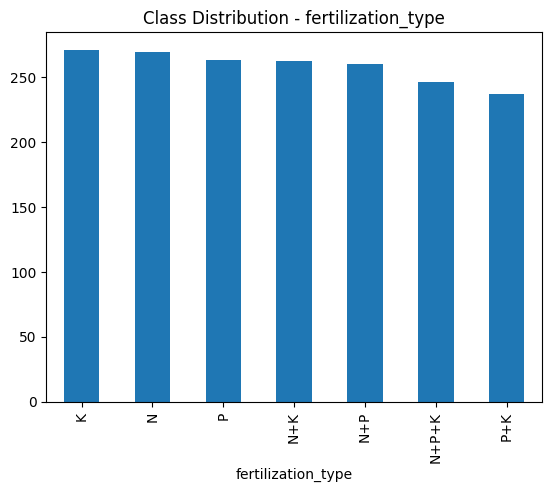

In [ ]:
print(df["fertilization_type"].value_counts())
import matplotlib.pyplot as plt
df["fertilization_type"].value_counts().plot(kind="bar")
plt.title("Class Distribution - fertilization_type")
plt.show()

In [ ]:
# SECTION 2: Preprocess the Data

# 🗓️ Extract month from date
df['date'] = pd.to_datetime(df['date'])  # تأكد من الصيغة
df['month'] = df['date'].dt.month

# 🟦 أضف هذا الكود مباشرة بعد استخراج الشهر من التاريخ

def get_growth_stage(month):
    if month in [8, 9, 10]:  # August, September, October
        return "Dormancy"
    elif month == 11:        # November
        return "Growth Stimulation"
    elif month in [12, 1]:   # December, January
        return "Vegetative Growth"
    elif month == 2:         # February
        return "Flowering"
    elif month in [3, 4]:    # March, April
        return "Corm Multiplication"
    elif month == 5:         # May
        return "Leaf Yellowing"
    else:
        return "Unknown"

df['growth_stage'] = df['month'].apply(get_growth_stage)

from sklearn.preprocessing import LabelEncoder
le_stage = LabelEncoder()
df['growth_stage_code'] = le_stage.fit_transform(df['growth_stage'])



# 🧹 Drop unused columns
df.drop(columns=['date', 'time'], inplace=True, errors='ignore')
# 🔢 Ensure numeric columns are float (except categoricals)
numeric_columns = ['temperature', 'humidity', 'ph', 'sc', 'sh', 'st', 'n', 'p', 'k', 'n_amount', 'p_amount', 'k_amount']
df[numeric_columns] = df[numeric_columns].astype(float)

# ✅ Check value distribution in classification columns
print("🔹 Fertilization Need:", df['fertilization_need'].value_counts())
print("🔹 Fertilization Type:", df['fertilization_type'].value_counts())

# 🧾 Check result
print("\n✅ Processed Columns:", df.columns.tolist())
print("\n🧪 Final datatypes:")
print(df.dtypes)

🔹 Fertilization Need: fertilization_need
1    8756
0    5860
Name: count, dtype: int64
🔹 Fertilization Type: fertilization_type
K        271
N        269
P        263
N+K      262
N+P      260
N+P+K    246
P+K      237
Name: count, dtype: int64

✅ Processed Columns: ['temperature', 'humidity', 'n', 'p', 'k', 'sc', 'st', 'sh', 'stage', 'ph', 'irrigation_need', 'irrigation_amount', 'fertilization_need', 'fertilization_type', 'n_amount', 'p_amount', 'k_amount', 'month', 'growth_stage', 'growth_stage_code']

🧪 Final datatypes:
temperature           float64
humidity              float64
n                     float64
p                     float64
k                     float64
sc                    float64
st                    float64
sh                    float64
stage                  object
ph                    float64
irrigation_need         int64
irrigation_amount     float64
fertilization_need      int64
fertilization_type     object
n_amount              float64
p_amount             

# 📌 🔶 SECTION 3: Feature Selection

In [ ]:
!pip install lightgbm
!pip install catboost
!pip install catboost imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [ ]:
# استيراد جميع المكتبات في الأعلى
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMClassifier  # <-- هذا السطر أضفه هنا
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# ثم بعدها سيكشن الفيتشرز والتقسيم وبقية الكود...

In [ ]:
def fert_type_combo(row):
    short = []
    if row["n"] < 20:
        short.append("N")
    if row["p"] < 60:
        short.append("P")
    if row["k"] < 40:
        short.append("K")
    if short:
        return "+".join(short)
    else:
        return "Mixed"  # أو "None"

df["fert_pred"] = df.apply(fert_type_combo, axis=1)
print((df["fertilization_type"] == df["fert_pred"]).mean())
print(df[["n", "p", "k", "fertilization_type", "fert_pred"]].sample(10))


0.013615216201423098
           n      p      k fertilization_type fert_pred
1363   21.70  60.93  42.86                NaN     Mixed
5600   20.77  23.36  28.03                NaN       P+K
6325   25.60  29.24  23.06                N+P       P+K
2099   26.10  75.81  42.29                NaN     Mixed
67     27.21  79.26  55.64                NaN     Mixed
7052   29.74  24.19  20.71                NaN       P+K
944    21.60  78.29  51.13                NaN     Mixed
10399  45.31  46.39  50.15                P+K         P
13662  29.35  29.25  28.55                NaN       P+K
6413   24.47  20.43  26.14                NaN       P+K


In [ ]:
features = ["temperature", "humidity", "ph", "sc", "sh", "st", "n", "p", "k", "month", "growth_stage_code"]
df_need = df.dropna(subset=features + ["fertilization_need"])
df_type = df.dropna(subset=features + ["fertilization_need", "fertilization_type"])
mask_need = df["fertilization_need"] == 1
df_amounts = df[mask_need].dropna(subset=features + ["n_amount", "p_amount", "k_amount"])
# 2. تقسيم الداتا حسب المهمة:
df_need = df.dropna(subset=features + ["fertilization_need"])  # للـ need
df_type = df.dropna(subset=features + ["fertilization_need", "fertilization_type"])  # للـ type
mask_need = df["fertilization_need"] == 1
df_amounts = df[mask_need].dropna(subset=features + ["n_amount", "p_amount", "k_amount"])  # للـ amounts

print(df_need["fertilization_need"].value_counts())
print(df_type["fertilization_need"].value_counts())
print(df_amounts["fertilization_need"].value_counts())

#y_type = df_type["fertilization_type"]
#rare_classes = y_type.value_counts()[y_type.value_counts() < 100].index.tolist()
#df_type["fertilization_type_mod"] = df_type["fertilization_type"].apply(lambda x: "Mixed" if x in rare_classes else x)

fertilization_need
1    8756
0    5860
Name: count, dtype: int64
fertilization_need
1    1808
Name: count, dtype: int64
fertilization_need
1    8756
Name: count, dtype: int64


In [ ]:
for col in ["n_to_p", "n_to_k", "p_to_k"]:
    for df_local in [df_need, df_type, df_amounts]:
        if col not in df_local.columns:
            df_local[col] = None

df_need["n_to_p"] = df_need["n"] / (df_need["p"] + 1e-6)
df_need["n_to_k"] = df_need["n"] / (df_need["k"] + 1e-6)
df_need["p_to_k"] = df_need["p"] / (df_need["k"] + 1e-6)

# كرر على بقية الداتا فريمات لو لازم


/tmp/ipython-input-93-395064092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_local[col] = None
/tmp/ipython-input-93-395064092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_local[col] = None
/tmp/ipython-input-93-395064092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

# 📌 🔶 SECTION 4: Split Data for Training & Testing

In [ ]:
from sklearn.model_selection import train_test_split

# 1. الحاجة للتسميد
X_need = df_need[features]
y_need = df_need["fertilization_need"]
X_need_train, X_need_test, y_need_train, y_need_test = train_test_split(
    X_need, y_need, test_size=0.2, random_state=42, stratify=y_need
)

# 2. نوع التسميد
X_type = df_type[features]
y_type = df_type["fertilization_type"]
X_type_train, X_type_test, y_type_train, y_type_test = train_test_split(
    X_type, y_type, test_size=0.2, random_state=42, stratify=y_type
)
# بعد التقسيم
# تشفير الكلاسات
from sklearn.preprocessing import LabelEncoder
le_type = LabelEncoder()
y_type_train_enc = le_type.fit_transform(y_type_train)

# تعريف باراميترات التجربة
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
}

lgbm = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(lgbm, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_type_train, y_type_train_enc)

# أفضل مودل
best_model_lgb = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

# 3. كميات N/P/K (فقط لمن يحتاج تسميد وكل القيم موجودة)
X_reg = df_amounts[features]
y_n = df_amounts["n_amount"]
y_p = df_amounts["p_amount"]
y_k = df_amounts["k_amount"]

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_reg, y_n, test_size=0.2, random_state=42)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_reg, y_p, test_size=0.2, random_state=42)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_reg, y_k, test_size=0.2, random_state=42)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2282
[LightGBM] [Info] Number of data points in the train set: 1446, number of used features: 11
[LightGBM] [Info] Start training from score -1.896659
[LightGBM] [Info] Start training from score -1.905918
[LightGBM] [Info] Start training from score -1.934222
[LightGBM] [Info] Start training from score -1.939018
[LightGBM] [Info] Start training from score -1.993353
[LightGBM] [Info] Start training from score -1.929449
[LightGBM] [Info] Start training from score -2.029532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [ ]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

le_type = LabelEncoder()
y_type_train_enc = le_type.fit_transform(y_type_train)

# طبق SMOTE بعد الترميز
smote = SMOTE(random_state=42)
X_type_train_bal, y_type_train_bal_enc = smote.fit_resample(X_type_train, y_type_train_enc)

# 📌 🔶 SECTION 5: Train  the Models

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier

# (1) Need
model_need = XGBClassifier(n_estimators=200, random_state=42)
model_need.fit(X_need_train, y_need_train)

# (2) Type (CatBoost + SMOTE)
#model_type_cat = CatBoostClassifier(verbose=100, iterations=300, random_state=42)
#model_type_cat.fit(X_type_train_bal, y_type_train_bal_enc)

# تدريب LightGBM على النوع
model_type_lgbm = LGBMClassifier(n_estimators=500, random_state=42)
model_type_lgbm.fit(X_type_train_bal, y_type_train_bal_enc)


# (3) Amounts (N/P/K)
model_n_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_n_rf.fit(X_train_n, y_train_n)
model_n_cb = CatBoostRegressor(verbose=0, random_state=42)
model_n_cb.fit(X_train_n, y_train_n)

model_p_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_p_rf.fit(X_train_p, y_train_p)
model_p_cb = CatBoostRegressor(verbose=0, random_state=42)
model_p_cb.fit(X_train_p, y_train_p)

model_k_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_k_rf.fit(X_train_k, y_train_k)
model_k_cb = CatBoostRegressor(verbose=0, random_state=42)
model_k_cb.fit(X_train_k, y_train_k)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 11
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

# 📌 🔶 SECTION 6: Testing & Evaluation (With Standardization)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ----- (1) Fertilization Need -----
print("\n🔹 Fertilization Need (Classification):")
y_need_pred = model_need.predict(X_need_test)
print(f"Accuracy: {accuracy_score(y_need_test, y_need_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_need_test, y_need_pred, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_need_test, y_need_pred, average='weighted')*100:.2f}%")
print(f"F1 Score: {f1_score(y_need_test, y_need_pred, average='weighted')*100:.2f}%")
print(classification_report(y_need_test, y_need_pred))

# ----- (2) Fertilization Type -----
print("\n🔹 Fertilization Type (Classification):")
# إذا استخدمت LabelEncoder لازم ترجع التحويل
#y_type_test_enc = le_type.transform(y_type_test)
#y_type_pred_enc = model_type_cat.predict(X_type_test)

#y_type_pred_enc = model_type_lgbm.predict(X_type_test)
#y_type_pred = le_type.inverse_transform(y_type_pred_enc)

y_type_pred_enc = best_model_lgb.predict(X_type_test)
y_type_pred = le_type.inverse_transform(y_type_pred_enc)

from sklearn.metrics import classification_report, accuracy_score
print("🔹 Fertilization Type (Classification):")
print(f"Accuracy: {accuracy_score(y_type_test, y_type_pred)*100:.2f}%")
print(classification_report(y_type_test, y_type_pred))

#y_type_pred_enc = model_type.predict(X_type_test)
#y_type_pred = le_type.inverse_transform(y_type_pred_enc)

print(f"Accuracy: {accuracy_score(y_type_test, y_type_pred)*100:.2f}%")
print(classification_report(y_type_test, y_type_pred))


🔹 Fertilization Need (Classification):
Accuracy: 97.54%
Precision: 97.54%
Recall: 97.54%
F1 Score: 97.54%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1172
           1       0.98      0.98      0.98      1752

    accuracy                           0.98      2924
   macro avg       0.98      0.97      0.97      2924
weighted avg       0.98      0.98      0.98      2924


🔹 Fertilization Type (Classification):
🔹 Fertilization Type (Classification):
Accuracy: 14.09%
              precision    recall  f1-score   support

           K       0.12      0.13      0.12        54
           N       0.12      0.11      0.12        54
         N+K       0.15      0.13      0.14        53
         N+P       0.14      0.17      0.16        52
       N+P+K       0.14      0.16      0.15        49
           P       0.12      0.11      0.12        53
         P+K       0.20      0.17      0.18        47

    accuracy                        

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ سكشن التقيـيم لكل موديلات الكميات (N/P/K)
def regression_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
   # rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    acc = 1 - (mae / (y_true.max() if y_true.max() else 1))
    print(f"\n🔹 {label}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"Regression Accuracy (approx): {acc*100:.2f}%")
    print("-"*40)

from sklearn.preprocessing import StandardScaler

# ⭕ 1. N (Regression)
scaler_n = StandardScaler()
X_train_n_scaled = scaler_n.fit_transform(X_train_n)
X_test_n_scaled = scaler_n.transform(X_test_n)

print("\n◆ N Amount (Regression):")
# RandomForest
model_n_rf.fit(X_train_n_scaled, y_train_n)
regression_metrics(y_test_n, model_n_rf.predict(X_test_n_scaled), "N (RandomForest)")
# CatBoost
model_n_cb.fit(X_train_n_scaled, y_train_n)
regression_metrics(y_test_n, model_n_cb.predict(X_test_n_scaled), "N (CatBoost)")

# ⭕ 2. P (Regression)
scaler_p = StandardScaler()
X_train_p_scaled = scaler_p.fit_transform(X_train_p)
X_test_p_scaled = scaler_p.transform(X_test_p)

print("\n◆ P Amount (Regression):")
# RandomForest
model_p_rf.fit(X_train_p_scaled, y_train_p)
regression_metrics(y_test_p, model_p_rf.predict(X_test_p_scaled), "P (RandomForest)")
# CatBoost
model_p_cb.fit(X_train_p_scaled, y_train_p)
regression_metrics(y_test_p, model_p_cb.predict(X_test_p_scaled), "P (CatBoost)")

# ⭕ 3. K (Regression)
scaler_k = StandardScaler()
X_train_k_scaled = scaler_k.fit_transform(X_train_k)
X_test_k_scaled = scaler_k.transform(X_test_k)

print("\n◆ K Amount (Regression):")
# RandomForest
model_k_rf.fit(X_train_k_scaled, y_train_k)
regression_metrics(y_test_k, model_k_rf.predict(X_test_k_scaled), "K (RandomForest)")
# CatBoost
model_k_cb.fit(X_train_k_scaled, y_train_k)
regression_metrics(y_test_k, model_k_cb.predict(X_test_k_scaled), "K (CatBoost)")


◆ N Amount (Regression):

🔹 N (RandomForest)
MAE: 1.97
RMSE: 4.50
R² Score: 0.32
Regression Accuracy (approx): 92.07%
----------------------------------------

🔹 N (CatBoost)
MAE: 2.15
RMSE: 4.72
R² Score: 0.26
Regression Accuracy (approx): 91.38%
----------------------------------------

◆ P Amount (Regression):

🔹 P (RandomForest)
MAE: 1.82
RMSE: 4.26
R² Score: 0.31
Regression Accuracy (approx): 92.68%
----------------------------------------

🔹 P (CatBoost)
MAE: 1.94
RMSE: 4.34
R² Score: 0.28
Regression Accuracy (approx): 92.22%
----------------------------------------

◆ K Amount (Regression):

🔹 K (RandomForest)
MAE: 1.91
RMSE: 4.42
R² Score: 0.29
Regression Accuracy (approx): 92.32%
----------------------------------------

🔹 K (CatBoost)
MAE: 2.01
RMSE: 4.53
R² Score: 0.25
Regression Accuracy (approx): 91.92%
----------------------------------------


# 📌 🔶 SECTION 6: Visualize the Results

✅ 1. Classification Report for Fertilization Need & Type

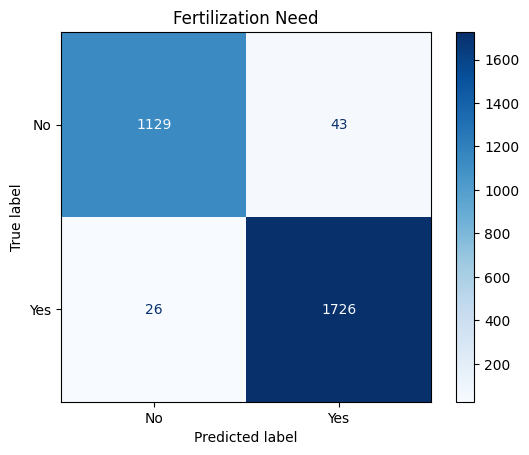

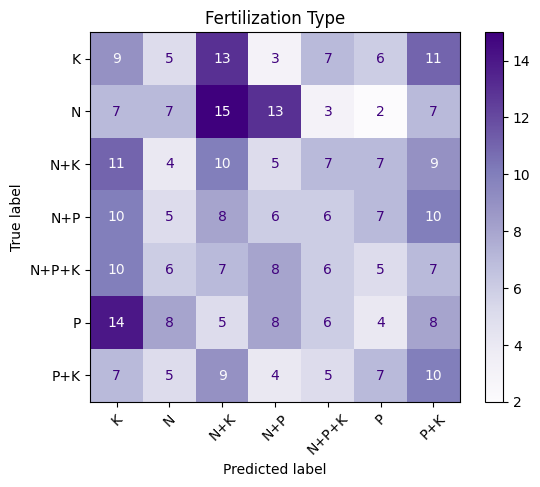

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_need = confusion_matrix(y_need_test, y_need_pred, labels=[0, 1])
disp_need  = ConfusionMatrixDisplay(confusion_matrix=cm_need, display_labels=['No', 'Yes']).plot(cmap='Blues')
plt.title("Fertilization Need")
plt.show()

cm_type = confusion_matrix(y_type_test, y_type_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_type, display_labels=le_type.classes_).plot(cmap='Purples')
plt.title("Fertilization Type")
plt.xticks(rotation=45)
plt.show()

✅ 2. Regression: Actual vs Predicted (Amount)

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_amount_test, y_amount_pred, alpha=0.6)
plt.plot([y_amount_test.min(), y_amount_test.max()],
         [y_amount_test.min(), y_amount_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Fertilization Amount (ml)")
plt.ylabel("Predicted Fertilization Amount (ml)")
plt.title("Actual vs Predicted Fertilization Amount")
plt.grid(True)
plt.show()

NameError: name 'y_amount_test' is not defined

<Figure size 800x500 with 0 Axes>

# 📌 🔶 SECTION 7: Residuals Analysis

✅ 1. Distribution of Residuals

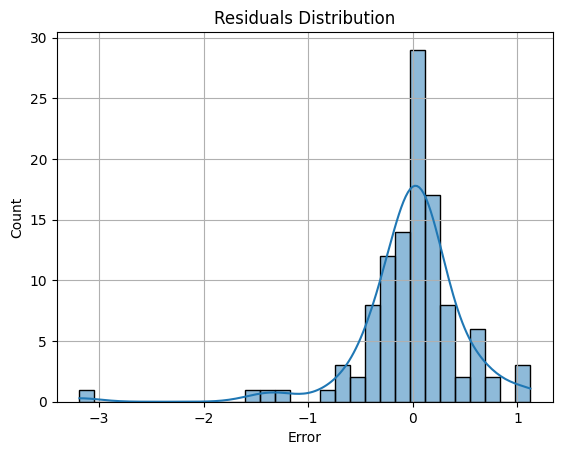

In [ ]:
residuals = y_amount_test - y_amount_pred
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.grid(True)
plt.show()

✅ 2. Residuals vs Predicted

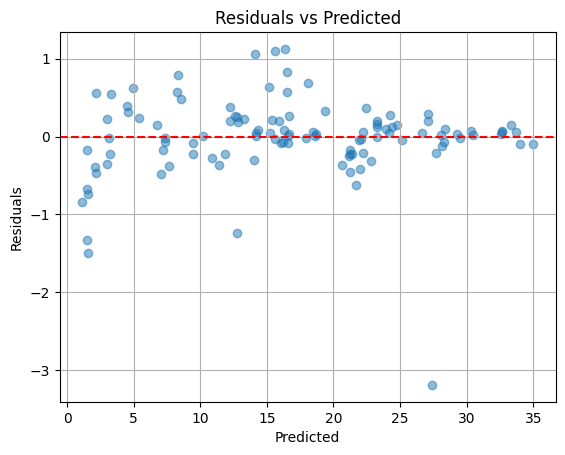

In [ ]:
plt.scatter(y_amount_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# 💾 SECTION 8: Save Models

In [ ]:
import joblib
joblib.dump(model_need, 'model_fertilization_need.pkl')
joblib.dump(best_model, 'model_fertilization_type.pkl')
joblib.dump(model_amount, 'model_fertilization_amount.pkl')
joblib.dump(le_type, 'label_encoder_type.pkl')

['label_encoder_type.pkl']

In [ ]:
import joblib
from google.colab import files

# حفظ النموذج الأول - احتياج التسميد
joblib.dump(model_need, "model_fertilization_need.pkl")
files.download("model_fertilization_need.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
from google.colab import files

# حفظ النموذج الثاني - نوع السماد
joblib.dump(best_model, "model_fertilization_type.pkl")
files.download("model_fertilization_type.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
from google.colab import files

# حفظ محول التصنيفات لنوع السماد
joblib.dump(le_type, "label_encoder_type.pkl")
files.download("label_encoder_type.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
from google.colab import files

# حفظ النموذج الثالث - كمية السماد
joblib.dump(model_amount, "model_fertilization_amount.pkl")
files.download("model_fertilization_amount.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 📌 🔶 SECTION 9: Evaluate on Future Data

In [ ]:
# 📌 🔶 SECTION 1: Load Models and Encoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score

# Load trained models
model_need = joblib.load("model_fertilization_need.pkl")
model_type = joblib.load("model_fertilization_type.pkl")
model_amount = joblib.load("model_fertilization_amount.pkl")
le_type = joblib.load("label_encoder_type.pkl")

In [ ]:
# 📌 🔶 SECTION 2: Load Data for Evaluation (with ground truth)
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
file_path = "/content/final_dataset_balanced.csv"
#df = pd.read_csv(file_path)
# Preprocessing
if 'date' in df.columns and 'time' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df['month'] = df['datetime'].dt.month
    df.drop(columns=['date', 'time'], inplace=True, errors='ignore')
elif 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df.drop(columns=['date'], inplace=True, errors='ignore')

# Define features
features = ["temperature", "humidity", "ph", "sc", "sh", "st", "n", "p", "k", "month"]
X_input = df[features]

# Save ground truth for comparison
true_need = df["fertilization_need"].copy()
true_type = df["fertilization_type"].copy()
true_amount = df["fertilization_amount"].copy()

# Remove fertilization columns for prediction
df.drop(columns=["fertilization_need", "fertilization_type", "fertilization_amount"], inplace=True, errors='ignore')

Saving final_dataset_balanced.csv to final_dataset_balanced (2).csv


In [ ]:
# 📌 🔶 SECTION 3: Run Predictions
# Step 1: Predict Fertilization Need
df['fertilization_need_pred'] = model_need.predict(X_input)

# Step 2: If needed, predict type and amount
mask = df['fertilization_need_pred'] == 1
X_needed = X_input[mask]
df['fertilization_type_pred'] = 'None'
df['fertilization_amount_pred'] = 0.0
df.loc[mask, 'fertilization_type_pred'] = le_type.inverse_transform(model_type.predict(X_needed))
df.loc[mask, 'fertilization_amount_pred'] = model_amount.predict(X_needed)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- humidity_temp_ratio
- is_dry
- is_hot
- npk_ratio


In [ ]:
# 📌 🔶 SECTION 4: Evaluate Performance
true_type = true_type.astype(str)
df['fertilization_type_pred'] = df['fertilization_type_pred'].astype(str)
need_acc = accuracy_score(true_need, df['fertilization_need_pred']) * 100
type_acc = accuracy_score(true_type, df['fertilization_type_pred']) * 100

actual_amt = true_amount[true_need == 1]
pred_amt = df.loc[true_need == 1, 'fertilization_amount_pred']
mae = mean_absolute_error(actual_amt, pred_amt)
r2 = r2_score(actual_amt, pred_amt)

print("\n📊 Fertilization Model Evaluation:")
print(f"🎯 Fertilization Need Accuracy: {need_acc:.2f}%")
print(f"💎 Fertilization Type Accuracy: {type_acc:.2f}%")
print(f"🧪 Fertilization Amount MAE: {mae:.2f} ml")
print(f"📈 Fertilization Amount R² Score: {r2:.2f}")


📊 Fertilization Model Evaluation:
🎯 Fertilization Need Accuracy: 75.79%
💎 Fertilization Type Accuracy: 75.65%
🧪 Fertilization Amount MAE: 0.24 ml
📈 Fertilization Amount R² Score: 1.00


In [ ]:
# 📌 🔶 SECTION 5: Optional - Save Predictions
df['fertilization_need_true'] = true_need
df['fertilization_type_true'] = true_type
df['fertilization_amount_true'] = true_amount
df.to_csv("fertilization_model_predictions_with_evaluation.csv", index=False)
print("\n✅ Results saved to fertilization_model_predictions_with_evaluation.csv")


✅ Results saved to fertilization_model_predictions_with_evaluation.csv
